<a href="https://colab.research.google.com/github/JulesLscx/M2_DeepLearning/blob/main/TD2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tensorflow tensorflow_datasets

In [2]:
!pip install tensorflow_io

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 MB 18.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 57.6 MB/s eta 0:00:00


In [3]:
import tensorflow_datasets as tfds
import tensorflow as tf
import tensorflow_io as tfio
from keras.utils import to_categorical
import keras

/usr/local/lib/python3.12/dist-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/usr/local/lib/python3.12/dist-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/usr/local/lib/python3.12/dist-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl5mutex6unlockEv']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/usr/local/lib/python3.12/dist-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/usr/local/lib/python3.12/dist-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/usr/local/lib/python3.12/dist-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZN3tsl7strings13safe_strtou64ESt17basic_string_viewIcSt11char_traitsIcEEPm']
  warnings.warn(

# Exo 1

In [4]:
(training_set, validation_set), dataset_info = tfds.load(
    'stanford_dogs',
    split=['train[:70%]', 'train[70%:]'],
    with_info=True,
    as_supervised=True,
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/stanford_dogs/incomplete.1X4G6C_0.2.0/stanford_dogs-train.tfrecord*...:   …

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/stanford_dogs/incomplete.1X4G6C_0.2.0/stanford_dogs-test.tfrecord*...:   0…

Dataset stanford_dogs downloaded and prepared to /root/tensorflow_datasets/stanford_dogs/0.2.0. Subsequent calls will reuse this data.


Il y'a 120 classes (races de chiens)

In [ ]:
tfds.show_examples(training_set, dataset_info)

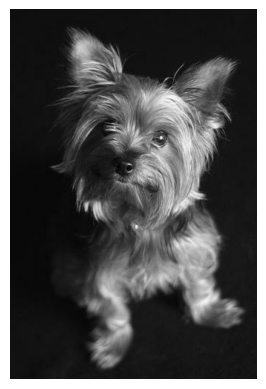

In [6]:
import matplotlib.pyplot as plt
for example in training_set.take(1):
    image = example[0]
    gray = tf.image.rgb_to_grayscale(image)
    # # Get label name from the info
    # label_name = dataset_info.features["label"].int2str(label)

    # Display the image
    plt.imshow(gray, cmap='gray')
    plt.axis("off")
    plt.show()

In [7]:
import numpy as np

In [8]:
print(np.shape(gray))
gray = tf.expand_dims(gray, axis=0)
np.shape(gray)

(500, 333, 1)


TensorShape([1, 500, 333, 1])

In [9]:
np.shape(gray)

TensorShape([1, 500, 333, 1])

In [10]:
perso_kernel = np.array(
    [
        [-2,0,-3],[0,4,0],[-2,0,-4]
    ], dtype=np.float32
)
perso_kernel = perso_kernel.reshape((3, 3, 1, 1))

In [11]:
gray = tf.cast(gray, 'float32')
output = tf.nn.conv2d(
    input=gray,
    filters=perso_kernel,
    strides=1,
    padding='SAME'
)

print("Forme de sortie :", output.shape)  # (1, 367, 400, 1)

# Affichage du résultat
plt.imshow(tf.squeeze(output), cmap='gray')
plt.title("Image filtrée")
plt.axis("off")
plt.show()

Forme de sortie : (1, 500, 333, 1)


Forme de sortie : (1, 500, 333, 1)


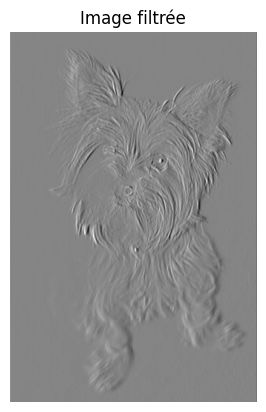

In [12]:
sobel = np.array(
    [
        [-1,0,1],[-2,0,2],[-1,0,1]
    ], dtype=np.float32
)
sobel = sobel.reshape((3, 3, 1, 1))
gray = tf.cast(gray, 'float32')
output = tf.nn.conv2d(
    input=gray,
    filters=sobel,
    strides=1,
    padding='SAME'
)

print("Forme de sortie :", output.shape)  # (1, 367, 400, 1)

# Affichage du résultat
plt.imshow(tf.squeeze(output), cmap='gray')
plt.title("Image filtrée")
plt.axis("off")
plt.show()

In [13]:
def encode_one_hot(image,label):
    label_one_hot = tf.one_hot(label, depth=120)
    return image, label_one_hot

In [14]:
training_set = training_set.map(encode_one_hot)
validation_set = validation_set.map(encode_one_hot)

In [15]:
preprocess = tf.keras.Sequential([
    tf.keras.layers.Resizing(128, 128),
    tf.keras.layers.Rescaling(1./255)
])

In [16]:
def preprocessing(image,label):
    image = preprocess(image)
    return image, label

In [17]:
preprocess_training_set = training_set.map(preprocessing)
preprocess_validation_set = validation_set.map(preprocessing)

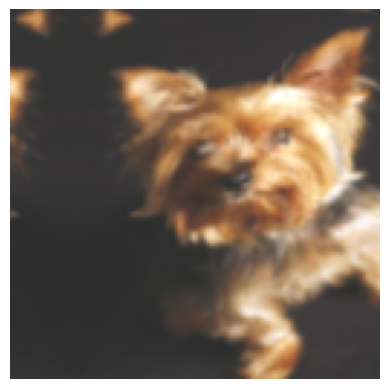

In [18]:
# Executer plusieurs fois pour voir les différences
for example in preprocess_training_set.take(1):
    image = example[0]
    data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.RandomBrightness(0.2,(0,1)),
    tf.keras.layers.RandomTranslation(0.2,0.2),
    ])
    output = data_augmentation(image)
    # # Get label name from the info
    # label_name = dataset_info.features["label"].int2str(label)

    # Display the image
    plt.imshow(output)
    plt.axis("off")
    plt.show()

# Exo 4

In [19]:
(training_beans,test_beans, validation_beans), beans_info = tfds.load(
    'beans',
    split=['train','test','validation'],
    with_info=True,
    as_supervised=True,
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/beans/incomplete.77GS5X_0.1.0/beans-train.tfrecord*...:   0%|          | 0…

Generating validation examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/beans/incomplete.77GS5X_0.1.0/beans-validation.tfrecord*...:   0%|        …

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/beans/incomplete.77GS5X_0.1.0/beans-test.tfrecord*...:   0%|          | 0/…

Dataset beans downloaded and prepared to /root/tensorflow_datasets/beans/0.1.0. Subsequent calls will reuse this data.


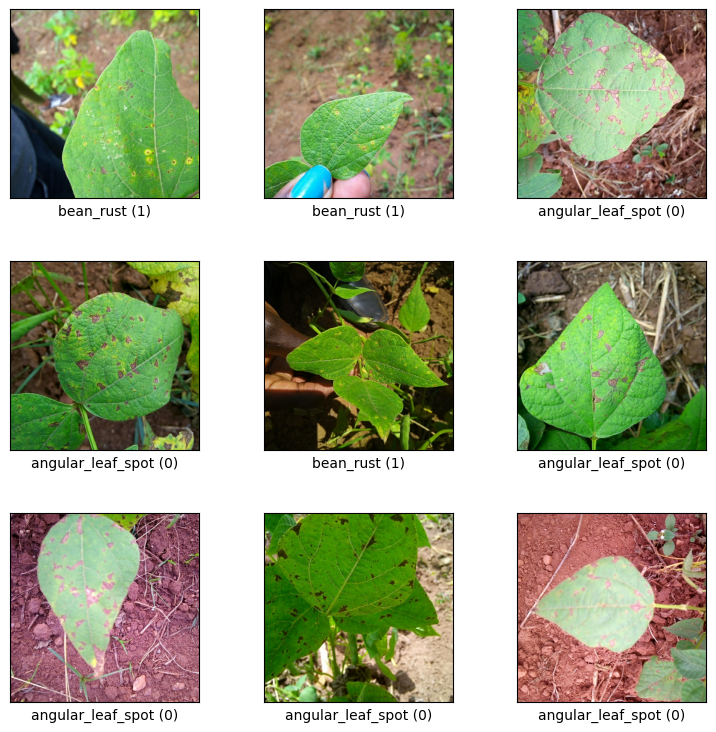

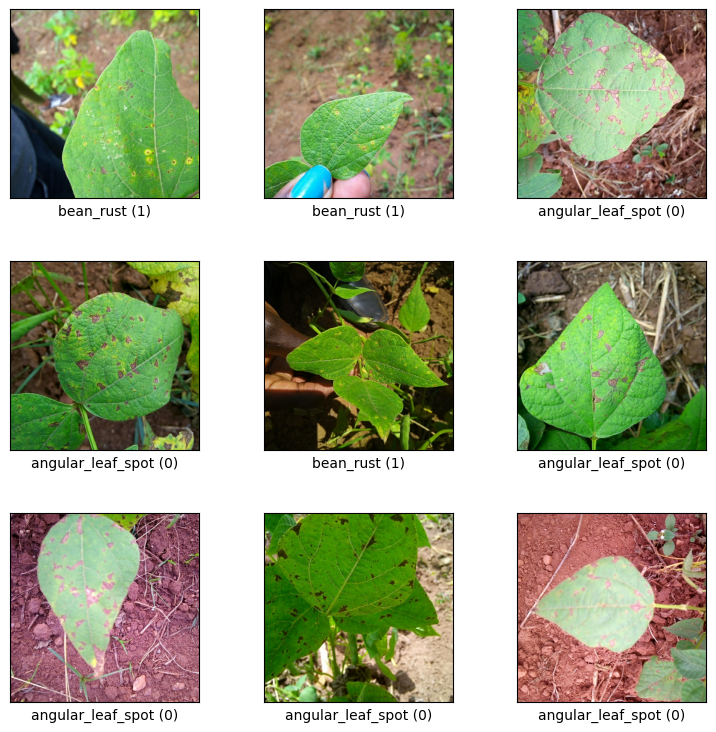

In [20]:
tfds.show_examples(training_beans, beans_info)

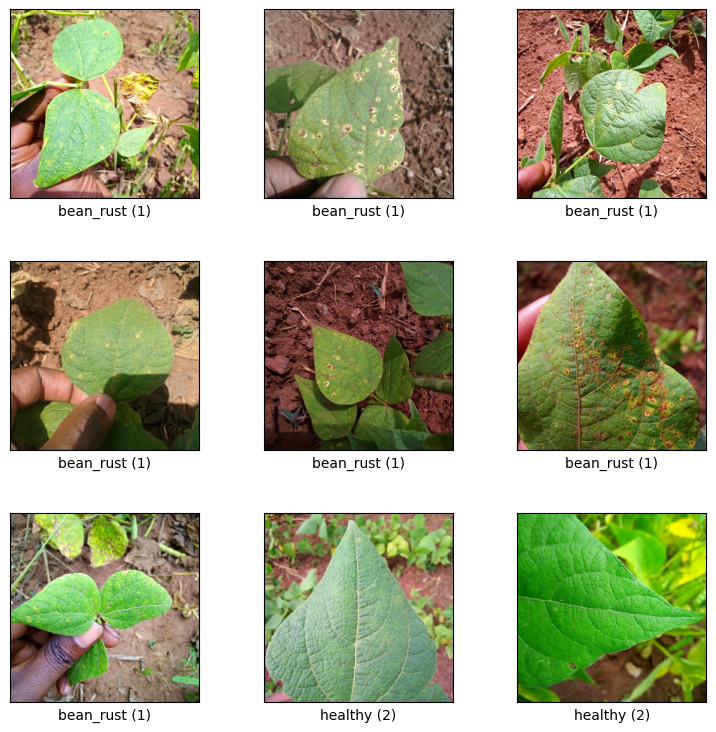

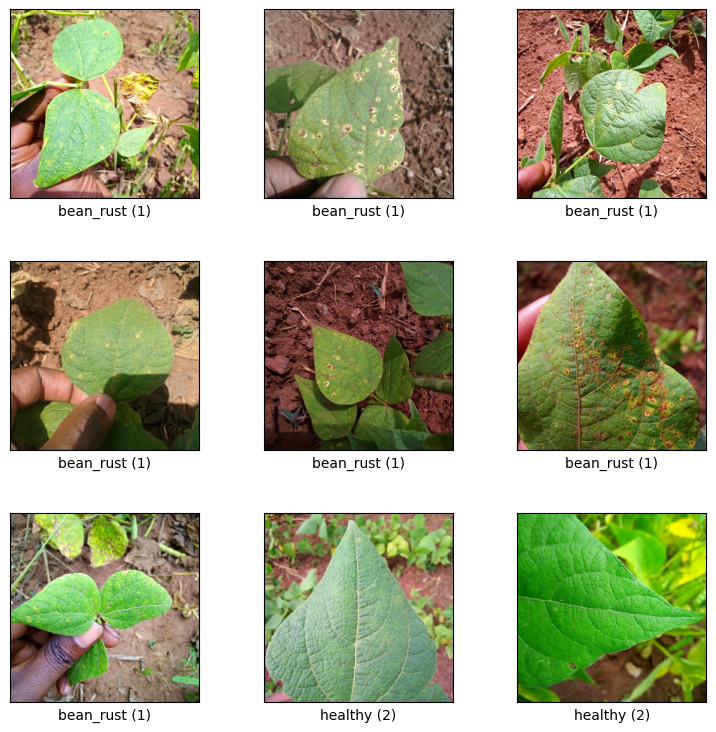

In [21]:
tfds.show_examples(validation_beans, beans_info)

In [22]:
beans_info

tfds.core.DatasetInfo(
    name='beans',
    full_name='beans/0.1.0',
    description="""
    Beans is a dataset of images of beans taken in the field using smartphone
    cameras. It consists of 3 classes: 2 disease classes and the healthy class.
    Diseases depicted include Angular Leaf Spot and Bean Rust. Data was annotated by
    experts from the National Crops Resources Research Institute (NaCRRI) in Uganda
    and collected by the Makerere AI research lab.
    """,
    homepage='https://github.com/AI-Lab-Makerere/ibean/',
    data_dir='/root/tensorflow_datasets/beans/0.1.0',
    file_format=tfrecord,
    download_size=171.69 MiB,
    dataset_size=171.63 MiB,
    features=FeaturesDict({
        'image': Image(shape=(500, 500, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=3),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    nondeterministic_order=False,
    splits={
        'test': <SplitInfo num_examples=128, num_

In [23]:
preprocess = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./255)
])
def global_preprocessing(img,lbl):
  return preprocess(img), tf.one_hot(lbl, depth=3)

In [38]:
preprocesss_beans_train = training_beans.map(global_preprocessing).batch(16).prefetch(tf.data.AUTOTUNE)
preprocesss_beans_test = test_beans.map(global_preprocessing).batch(16).prefetch(tf.data.AUTOTUNE)
preprocesss_beans_validation = validation_beans.map(global_preprocessing).batch(16).prefetch(tf.data.AUTOTUNE)

In [32]:
import tensorflow as tf
from tensorflow.keras import layers, models
def augmented_model():
    data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.RandomBrightness(0.2,(0,1)),
    tf.keras.layers.RandomTranslation(0.2,0.2),
    ])
    return data_augmentation

def build_model(num_classes=3):

    model = models.Sequential()
    model.add(augmented_model())
    # --- Bloc 1 ---
    model.add(layers.Conv2D(32, (3, 3), padding='same', activation='relu',input_shape=(500, 500, 3)))
    model.add(layers.Conv2D(32, (3, 3), padding='same', activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))

    # --- Bloc 2 ---
    model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))

    # --- Bloc 3 ---
    model.add(layers.Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(layers.Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))

    # --- Flatten + Dense finale ---
    model.add(layers.Flatten())
    model.add(layers.Dense(1024, activation='relu'))
    model.add(layers.Dropout(0.2))
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(num_classes, activation='softmax'))

    return model


In [33]:
model = build_model( num_classes=3)
model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_6 (Sequential)       │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [34]:
model.compile(loss='categorical_crossentropy',
                    optimizer='adam',
                    metrics=['accuracy'])

In [35]:
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_6 (Sequential)       │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [39]:
hist = model.fit(
    preprocesss_beans_train, epochs=10, validation_data = preprocesss_beans_test, verbose=1)

Epoch 1/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 59s 769ms/step - accuracy: 0.4828 - loss: 2.7559 - val_accuracy: 0.3359 - val_loss: 4.9486
Epoch 2/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 73s 774ms/step - accuracy: 0.5570 - loss: 1.0938 - val_accuracy: 0.3359 - val_loss: 4.9496
Epoch 3/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 82s 773ms/step - accuracy: 0.5960 - loss: 0.9869 - val_accuracy: 0.3359 - val_loss: 2.9514
Epoch 4/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 82s 769ms/step - accuracy: 0.5915 - loss: 0.9093 - val_accuracy: 0.3359 - val_loss: 3.4911
Epoch 5/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 49s 754ms/step - accuracy: 0.6341 - loss: 0.8425 - val_accuracy: 0.3359 - val_loss: 2.3194
Epoch 6/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 83s 775ms/step - accuracy: 0.5765 - loss: 0.9957 - val_accuracy: 0.3438 - val_loss: 2.0514
Epoch 7/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 82s 774ms/step - accuracy: 0.6425 - loss: 0.8694 - val_accuracy: 0.7266 - val_loss: 0.6329
Epoch 8/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 82s 773ms/step - accuracy: 0.6568 - loss: 0.8273 - val_accu

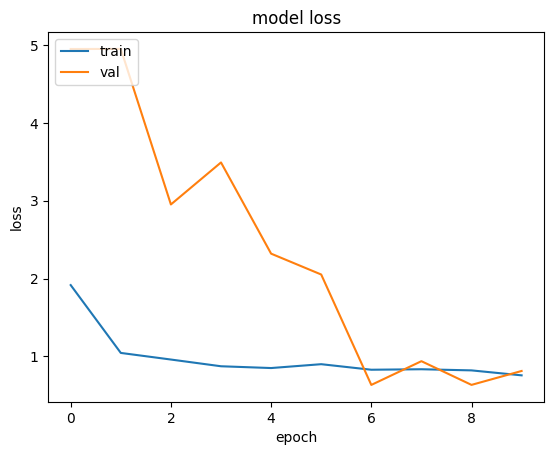

In [40]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

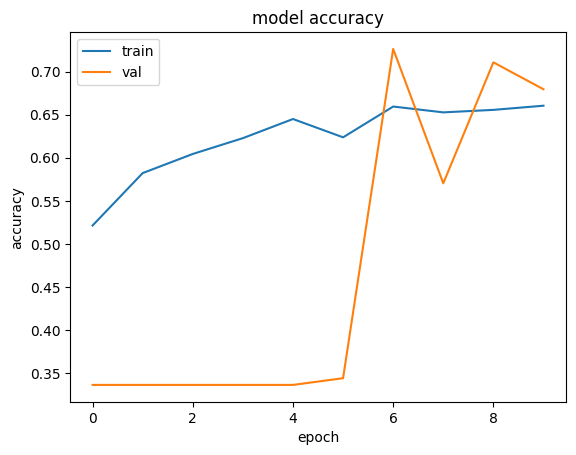

In [44]:
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()